In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [14]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

In [4]:
print(len(df['발주처'].unique()))

81


## 클리닝

In [15]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [16]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [22]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

# 리드타임이 1일 미만이거나 200일을 초과한 경우 제거
df = df[(df['리드타임'] > 0 ) & (df['리드타임'] <=160)]

# 창고입고가 결측값인 행 제거
df = df.dropna(subset=['창고입고'])

print(df.shape)

(18804, 33)


In [23]:
columns_to_keep = ['Machinery', 'Assembly', '청구품목', '발주처', '견적화폐', '견적단가', '발주수량', '발주', '창고입고', '리드타임']
df = df[columns_to_keep]

In [24]:
print(df.isnull().sum())

Machinery    0
Assembly     0
청구품목         0
발주처          0
견적화폐         0
견적단가         0
발주수량         0
발주           0
창고입고         0
리드타임         0
dtype: int64


In [25]:
print(df['리드타임'].describe())


count    18804.000000
mean        62.048447
std         46.321266
min          1.000000
25%         18.000000
50%         56.000000
75%         97.000000
max        160.000000
Name: 리드타임, dtype: float64


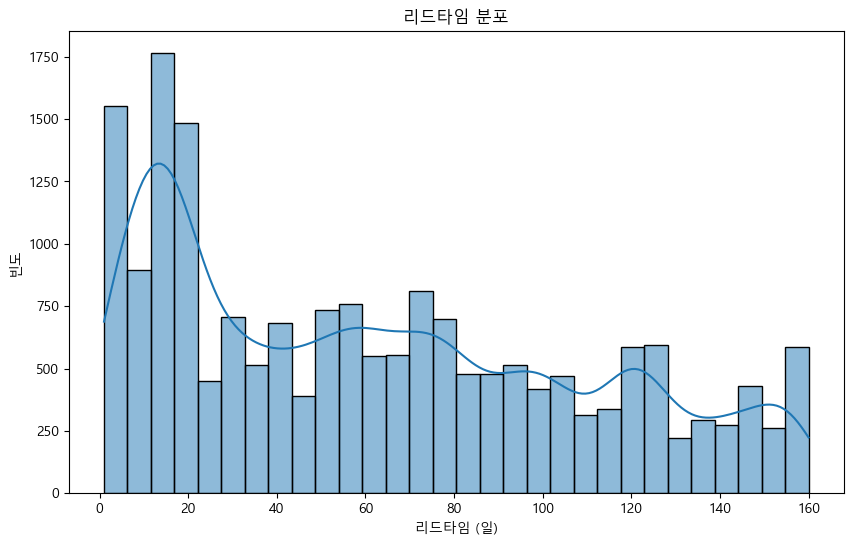

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family']='Malgun Gothic'

plt.figure(figsize=(10, 6))
sns.histplot(df['리드타임'], bins=30, kde=True)
plt.title('리드타임 분포')
plt.xlabel('리드타임 (일)')
plt.ylabel('빈도')
plt.show()

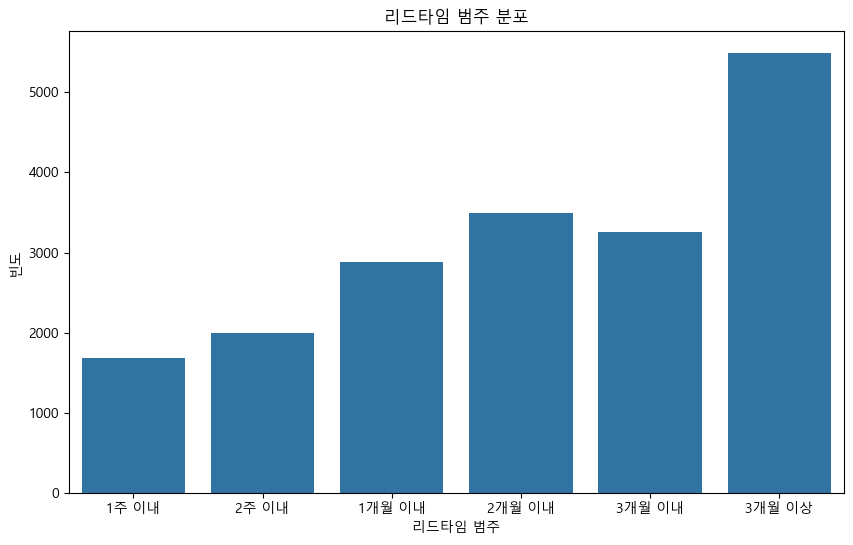

In [27]:
df['리드타임_범주'] = pd.cut(df['리드타임'], bins=[0, 7, 14, 30, 60, 90, df['리드타임'].max()], labels=['1주 이내', '2주 이내', '1개월 이내', '2개월 이내', '3개월 이내', '3개월 이상'])
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='리드타임_범주')
plt.title('리드타임 범주 분포')
plt.xlabel('리드타임 범주')
plt.ylabel('빈도')
plt.show()

### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 및 BERT 임베딩
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

## 전처리

> 각 텍스트 필드 개별적으로 rf idf 변환하고 결합

In [28]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [29]:
text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)


In [40]:
#!conda install conda-forge::category_encoders -y

In [30]:
import category_encoders as ce

# 발주처의 전처리
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

# 발주처를 스무딩이 적용된 타겟 인코딩 (리드타임을 목표 변수로 가정)
target_encoder = ce.TargetEncoder(cols=['cleaned_supplier'], smoothing=10)
df['발주처_encoded'] = target_encoder.fit_transform(df['cleaned_supplier'], df['리드타임'])

# 결과 확인
print(df[['cleaned_supplier', '발주처_encoded', '리드타임']].head())

  cleaned_supplier  발주처_encoded  리드타임
0       matsui_usa     81.49162   112
1       matsui_usa     81.49162    97
2       matsui_usa     81.49162   112
3       matsui_usa     81.49162     1
4       matsui_usa     81.49162     1


### 데이터 분할

> 로그 변환 및 tf-idf 벡터화 시 nan 값 생길 수 있으므로 처리에 주의요함

In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
from scipy.sparse import hstack, csr_matrix

# 환율 설정
exchange_rate = {
    'KRW': 1/1300, 
    'USD': 1,      
    'EUR': 1.1,     
    'JPY': 1/110    
}

# 1. 수치형 데이터 처리 (로그 변환 및 NaN 처리)
df['converted_unit_price'] = df.apply(lambda x: x['견적단가'] * exchange_rate[x['견적화폐']], axis=1)
df['converted_price'] = df['converted_unit_price'] * df['발주수량']

# 로그 변환 전에 0 이하의 값 제거
df = df[df['converted_price'] > 0]

# 로그 변환 후 NaN 값 제거
df['log_converted_price'] = np.log1p(df['converted_price'])

# 수치형 데이터에 대해 NaN 제거
df = df.dropna(subset=['log_converted_price', '발주수량'])



In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_machinery = TfidfVectorizer(max_features=5000)  
tfidf_assembly = TfidfVectorizer(max_features=5000)
tfidf_item = TfidfVectorizer(max_features=5000)

tfidf_machinery_matrix = tfidf_machinery.fit_transform(df['cleaned_machinery'])
tfidf_assembly_matrix = tfidf_assembly.fit_transform(df['cleaned_assembly'])
tfidf_item_matrix = tfidf_item.fit_transform(df['cleaned_item'])

print(f"TF-IDF Machinery Shape: {tfidf_machinery_matrix.shape}")
print(f"TF-IDF Assembly Shape: {tfidf_assembly_matrix.shape}")
print(f"TF-IDF Item Shape: {tfidf_item_matrix.shape}")

TF-IDF Machinery Shape: (18758, 135)
TF-IDF Assembly Shape: (18758, 1607)
TF-IDF Item Shape: (18758, 2837)


In [33]:
# 3. 수치형 데이터 스케일링
scaler = StandardScaler()
log_price_scaled = scaler.fit_transform(df[['log_converted_price']])
quantity = df[['발주수량']].values

In [34]:
# 7. 화폐 단위 One-Hot 인코딩
currency_ohe = OneHotEncoder(sparse_output=False)
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

# 5. 수치형 데이터 결합 
X_combined_numeric = np.hstack([
    log_price_scaled, 
    quantity, 
    df['발주처_encoded'].values.reshape(-1, 1), 
    currency_encoded
])

X_text = hstack([tfidf_machinery_matrix, tfidf_assembly_matrix, tfidf_item_matrix])
X_text_dense = X_text.toarray()

# 수치형 데이터와 텍스트 데이터 모두에서 NaN이 없는 행 필터링
valid_rows = ~np.isnan(X_combined_numeric).any(axis=1) & ~np.isnan(X_text_dense).any(axis=1)

# 유효한 행으로 필터링
X_text_filtered = X_text_dense[valid_rows]
X_combined_numeric_filtered = X_combined_numeric[valid_rows]

# 7. 최종 결합 (희소 행렬로 변환하여 결합)
X_final = hstack([csr_matrix(X_text_filtered), csr_matrix(X_combined_numeric_filtered)])

# 결과 확인
print(f"Final Feature Shape: {X_final.shape}")

Final Feature Shape: (18758, 4586)


In [35]:

y = df['리드타임'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

In [144]:
# 10. 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 1729.4734436561055
Mean Absolute Error (MAE): 28.078028884469248
R^2 Score: 0.34482510203003125
